In [1]:
%reload_ext autoreload
%autoreload 2
# allow iterative matplotlib plots
%matplotlib widget
# %matplotlib inline

In [2]:
from IPython import display
import sys, os
sys.path.append(os.path.join(os.getcwd(),'..','..'))

import numpy as np
import torch
from tqdm import tqdm
from pyro.distributions.multivariate_studentt import MultivariateStudentT

import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from matplotlib import gridspec
import matplotlib
import seaborn as sns

from CBOSS.models.models import Constrained_Binary_Quad_Problem
from CBOSS.bayesian_models.regression import GaussianProcessRegression, StudentTProcessRegression
from CBOSS.bayesian_models.svgp import *
from CBOSS.bayesian_models.kernels import PolynomialKernel, CombKernel, DiscreteDiffusionKernel, HammingKernel, RBFKernel

2024-03-01 14:48:03,488 [INFO] 
Limited Linear Model Support Detected! 
---> PYCHEBFUN is not installed. 
---> Install pychebfun to use chebfun derivatives (https://github.com/pychebfun/pychebfun/) 
You can still use other methods 



In [3]:
figsize = (6.2,1.8)
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
sns.set_style('darkgrid')
matplotlib.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.size':        8,
    'figure.titlesize': 10,
    'figure.subplot.top': 0.95,
    'axes.formatter.use_mathtext': True,
    'axes.titlesize':   10,
    'axes.titlepad':    5,
    # 'axes.labelpad':    0,
    'axes.labelsize':   8,
    'legend.fontsize':  8,
    'xtick.labelsize':  8,
    'ytick.labelsize':  8,
    'xtick.major.pad':  0,
    'ytick.major.pad':  0,
})
tight_layout_args = dict(
    pad = 0.5
)
savefig_kwargs = dict(
    bbox_inches='tight', 
    pad_inches = 0
)
legend_args = dict(
    loc='upper center', bbox_to_anchor=(0.5, -0.40), ncol=4, 
    columnspacing=1.0, labelspacing=0.5, handletextpad=0.2, handlelength=1.5,
)

In [4]:
n_vars              = 20
alpha_f             = 1e2
lambda_f            = 1e-2
train_sizes         = np.linspace(50, 400, 6, dtype=int) # range(50, 100+1, 50) #range(50, 400+1, 50)
test_size           = train_sizes[-1]

In [5]:
model = Constrained_Binary_Quad_Problem(n_vars=n_vars, alpha_f=alpha_f, lambda_f=lambda_f, alpha_c=alpha_f, lambda_c=lambda_f)

In [6]:
# encoder = OneHotEncoder(product_space=self.model.product_space)
# evaluate train
X_train = model.sample(nbr_samples = max(train_sizes)).astype(int)
X_test  = model.sample(nbr_samples = test_size).astype(int)

# X_train = encoder.encode(X=Xc_train).astype(int)
y_train = model.evaluate(X=X_train)[0][:,0]
y_test  = model.evaluate(X=X_test)[0][:,0]

X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)
X_test  = torch.tensor(X_test)
y_test  = torch.tensor(y_test)

In [7]:
data = {}

for train_size in tqdm(train_sizes):
    
    X_train_i = X_train[:train_size]
    y_train_i = y_train[:train_size]
    
    X_test_i  = X_test
    
    # normalize data
    y_train_std, y_train_mean = np.nanstd(y_train_i), np.nanmean(y_train_i)
    y_train_i = (y_train_i - y_train_mean) / y_train_std
    y_test_i  = (y_test  - y_train_mean) / y_train_std
    
    data[train_size] = {
        'X_train': X_train_i,
        'y_train': y_train_i,
        'X_test':  X_test_i,
        'y_test':  y_test_i,
        'y_train_std':  y_train_std,
        'y_train_mean': y_train_mean
    }

    sigma2m_prior = 0.2

    reg_TP = StudentTProcessRegression(
        X = X_train_i,
        y = y_train_i,
        kernel = PolynomialKernel(variance_prior=0.5, degree=3),
        train_sigma2 = True,
        sigma2m_prior = sigma2m_prior
    ).double()
    reg_TP.fit()
    reg_TP.eval()
    
    data[train_size]['reg_TP']    = reg_TP
    data[train_size]['y_pred_TP'] = reg_TP(X_pred=X_test_i, include_noise=False)
    data[train_size]['error_mean_TP'] = torch.mean(torch.abs(data[train_size]['y_pred_TP'].loc - y_test_i))
    data[train_size]['error_std_TP']  = torch.std( torch.abs(data[train_size]['y_pred_TP'].loc - y_test_i))


    reg_GP = GaussianProcessRegression(
        X = X_train_i,
        y = y_train_i,
        kernel = PolynomialKernel(variance_prior=0.5, degree=3),
        train_sigma2 = True,
        sigma2_prior = sigma2m_prior
    ).double()
    reg_GP.fit()
    reg_GP.eval()

    data[train_size]['reg_GP']    = reg_GP
    data[train_size]['y_pred_GP'] = reg_GP(X_pred=X_test_i, include_noise=False)
    data[train_size]['error_mean_GP'] = torch.mean(torch.abs(data[train_size]['y_pred_GP'].loc - y_test_i))
    data[train_size]['error_std_GP']  = torch.std( torch.abs(data[train_size]['y_pred_GP'].loc - y_test_i))

    N = X_train_i.shape[0]
    Ns = N
    s = torch.rand(N).argsort()[:Ns]
    svgpr = SVGP(
        X = X_train_i, 
        y = y_train_i, 
        s=torch.as_tensor(s),
        kernel = PolynomialKernel(variance_prior=0.5, degree=3),
        likelihood = GaussianLikelihood(sigma2_prior=sigma2m_prior, sigma2_hyperprior=1.),
        batch_size = N,
        optimizer = ['adam', 'lbfgs'][1]
    ).double()

    svgpr.fit(lr=1.0, maxiter=300)
    svgpr.eval()
    
    data[train_size]['reg_svgpr']    = svgpr
    data[train_size]['y_pred_svgpr'] = svgpr(X_pred=X_test_i, include_noise=False)
    data[train_size]['error_mean_svgpr'] = torch.mean(torch.abs(data[train_size]['y_pred_svgpr'].loc - y_test_i))
    data[train_size]['error_std_svgpr']  = torch.std( torch.abs(data[train_size]['y_pred_svgpr'].loc - y_test_i))


  0%|          | 0/6 [00:00<?, ?it/s]


========  TPReg. train report ============
	Time elapsed: 0.2 s
	nbr iterations: 12
	nbr fun evals:  16

	K.variance_prior               : [0.50] -> [0.12]
	sigma2m_prior_                 : [0.20] -> [0.06]
	L_prior_                       : [2.50] -> [3.05]
======== EOF TPReg. train report ==========


========  GPReg. train report ============
	Time elapsed: 0.2 s
	nbr iterations: 9
	nbr fun evals:  12

	K.variance_prior               : [0.50] -> [7.0e-03]
	sigma2                         : [0.20] -> [0.06]
======== EOF GPReg. train report ==========



 17%|█▋        | 1/6 [00:02<00:11,  2.39s/it]


========  SVGP train report ============
	Time elapsed:   1.9 s
	nbr evals:      35
	elbo:           -7.0e+01
	
	likelihood.sigma2              : [0.20] -> [0.81]
	K.variance_prior               : [0.50] -> [8.0e-04]
======== EOF SVGP train report ==========


========  TPReg. train report ============
	Time elapsed: 0.2 s
	nbr iterations: 13
	nbr fun evals:  14

	K.variance_prior               : [0.50] -> [0.35]
	sigma2m_prior_                 : [0.20] -> [0.02]
	L_prior_                       : [2.50] -> [2.86]
======== EOF TPReg. train report ==========


========  GPReg. train report ============
	Time elapsed: 0.6 s
	nbr iterations: 18
	nbr fun evals:  26

	K.variance_prior               : [0.50] -> [5.7e-03]
	sigma2                         : [0.20] -> [0.02]
======== EOF GPReg. train report ==========



 33%|███▎      | 2/6 [00:07<00:15,  3.79s/it]


========  SVGP train report ============
	Time elapsed:   3.8 s
	nbr evals:      75
	elbo:           -1.5e+02
	
	likelihood.sigma2              : [0.20] -> [0.23]
	K.variance_prior               : [0.50] -> [3.5e-03]
======== EOF SVGP train report ==========


========  TPReg. train report ============
	Time elapsed: 1.7 s
	nbr iterations: 20
	nbr fun evals:  57

	K.variance_prior               : [0.50] -> [0.80]
	sigma2m_prior_                 : [0.20] -> [0.01]
	L_prior_                       : [2.50] -> [2.73]
======== EOF TPReg. train report ==========


========  GPReg. train report ============
	Time elapsed: 1.5 s
	nbr iterations: 29
	nbr fun evals:  45

	K.variance_prior               : [0.50] -> [5.6e-03]
	sigma2                         : [0.20] -> [0.01]
======== EOF GPReg. train report ==========



 50%|█████     | 3/6 [00:16<00:19,  6.34s/it]


========  SVGP train report ============
	Time elapsed:   6.1 s
	nbr evals:      99
	elbo:           -2.3e+02
	
	likelihood.sigma2              : [0.20] -> [0.15]
	K.variance_prior               : [0.50] -> [3.8e-03]
======== EOF SVGP train report ==========


========  TPReg. train report ============
	Time elapsed: 0.8 s
	nbr iterations: 32
	nbr fun evals:  34

	K.variance_prior               : [0.50] -> [0.93]
	sigma2m_prior_                 : [0.20] -> [0.01]
	L_prior_                       : [2.50] -> [2.59]
======== EOF TPReg. train report ==========


========  GPReg. train report ============
	Time elapsed: 1.2 s
	nbr iterations: 30
	nbr fun evals:  45

	K.variance_prior               : [0.50] -> [5.2e-03]
	sigma2                         : [0.20] -> [0.01]
======== EOF GPReg. train report ==========



 67%|██████▋   | 4/6 [00:26<00:15,  7.81s/it]


========  SVGP train report ============
	Time elapsed:   7.9 s
	nbr evals:      112
	elbo:           -2.8e+02
	
	likelihood.sigma2              : [0.20] -> [0.09]
	K.variance_prior               : [0.50] -> [3.8e-03]
======== EOF SVGP train report ==========


========  TPReg. train report ============
	Time elapsed: 0.6 s
	nbr iterations: 28
	nbr fun evals:  29

	K.variance_prior               : [0.50] -> [1.01]
	sigma2m_prior_                 : [0.20] -> [0.01]
	L_prior_                       : [2.50] -> [2.28]
======== EOF TPReg. train report ==========


========  GPReg. train report ============
	Time elapsed: 1.1 s
	nbr iterations: 31
	nbr fun evals:  33

	K.variance_prior               : [0.50] -> [4.6e-03]
	sigma2                         : [0.20] -> [0.01]
======== EOF GPReg. train report ==========



 83%|████████▎ | 5/6 [00:38<00:09,  9.41s/it]


========  SVGP train report ============
	Time elapsed:   10.4 s
	nbr evals:      115
	elbo:           -3.3e+02
	
	likelihood.sigma2              : [0.20] -> [0.07]
	K.variance_prior               : [0.50] -> [3.4e-03]
======== EOF SVGP train report ==========


========  TPReg. train report ============
	Time elapsed: 1.8 s
	nbr iterations: 32
	nbr fun evals:  72

	K.variance_prior               : [0.50] -> [1.17]
	sigma2m_prior_                 : [0.20] -> [0.01]
	L_prior_                       : [2.50] -> [1.66]
======== EOF TPReg. train report ==========


========  GPReg. train report ============
	Time elapsed: 1.0 s
	nbr iterations: 26
	nbr fun evals:  28

	K.variance_prior               : [0.50] -> [3.7e-03]
	sigma2                         : [0.20] -> [0.01]
======== EOF GPReg. train report ==========



100%|██████████| 6/6 [00:55<00:00,  9.26s/it]


========  SVGP train report ============
	Time elapsed:   13.7 s
	nbr evals:      144
	elbo:           -3.4e+02
	
	likelihood.sigma2              : [0.20] -> [0.05]
	K.variance_prior               : [0.50] -> [2.7e-03]
======== EOF SVGP train report ==========



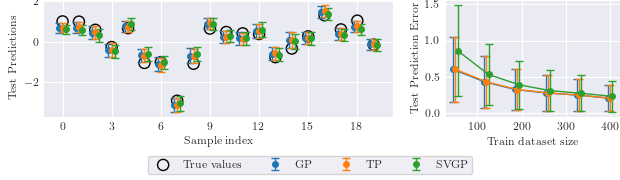

In [8]:

nps = 20
train_size = 400

# fig, ax = plt.subplots(1,1,figsize=(3.2,2))

fig = plt.figure(figsize=(6.2, 1.8))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])


ax = fig.add_subplot(gs[0,0])
# plot for test_size
ax.scatter( 
    np.arange(nps), 
    data[train_size]['y_test'].detach().numpy()[:nps],
    c='k', s=8**2, marker=MarkerStyle('o', 'none'), lw=1.0,
    label='True values'
)
ax.errorbar(
    x=np.arange(nps) -0.2, 
    y=data[train_size]['y_pred_GP'].mean.detach().numpy()[:nps], 
    yerr=data[train_size]['y_pred_GP'].variance.detach().numpy()[:nps] ** 0.5,
    c='tab:blue',
    ls="", lw=1, ms=4, capsize=3, capthick=1, marker=MarkerStyle('o', 'full'), markeredgewidth=1, 
    label='GP'
)
ax.errorbar(
    x=np.arange(nps), 
    y=data[train_size]['y_pred_TP'].mean.detach().numpy()[:nps], 
    yerr=data[train_size]['y_pred_TP'].variance.detach().numpy()[:nps] ** 0.5,
    c='tab:orange',
    ls="", lw=1, ms=4, capsize=3, capthick=1, marker=MarkerStyle('o', 'full'), markeredgewidth=1, 
    label='TP'
)
ax.errorbar(
    x=np.arange(nps) + 0.2,  
    y=data[test_size]['y_pred_svgpr'].mean.detach().numpy()[:nps], 
    yerr=data[test_size]['y_pred_svgpr'].variance.detach().numpy()[:nps] ** 0.5,
    c='tab:green', 
    ls="", lw=1, ms=4, capsize=3, capthick=1, marker=MarkerStyle('o', 'full'), markeredgewidth=1, 
    label='SVGP'
)

from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.grid(True)
ax.set_xlabel('Sample index')
ax.set_ylabel(f'Test Predictions')
h1,l1 = ax.get_legend_handles_labels()


# fig, axs = plt.subplots(1,1,figsize=(2.5,2))
ax = fig.add_subplot(gs[0,1])

GP_error_mean = [data[train_size]['error_mean_GP'] for train_size in train_sizes]
GP_error_std  = [data[train_size]['error_std_GP'] for train_size in train_sizes]

TP_error_mean = [data[train_size]['error_mean_TP'] for train_size in train_sizes]
TP_error_std  = [data[train_size]['error_std_TP'] for train_size in train_sizes]

svgpr_error_mean = [data[train_size]['error_mean_svgpr'] for train_size in train_sizes]
svgpr_error_std  = [data[train_size]['error_std_svgpr'] for train_size in train_sizes]
    
ax.errorbar(
    x=train_sizes - 5, 
    y=GP_error_mean, 
    yerr=GP_error_std,
    c='tab:blue', label='TP predictions',
    ls="-", lw=1, ms=4, capsize=3, capthick=1, marker=MarkerStyle('o', 'full'), markeredgewidth=1, 
)
ax.errorbar(
    x=train_sizes, 
    y=TP_error_mean, 
    yerr=TP_error_std,
    c='tab:orange', label='GP predictions',
    ls="-", lw=1, ms=4, capsize=3, capthick=1, marker=MarkerStyle('o', 'full'), markeredgewidth=1, 
)
ax.errorbar(
    x=train_sizes + 5, 
    y=svgpr_error_mean, 
    yerr=svgpr_error_std,
    c='tab:green', label='SVGP predictions',
    ls="-", lw=1, ms=4, capsize=3, capthick=1, marker=MarkerStyle('o', 'full'), markeredgewidth=1, 
)
ax.set_xlabel('Train dataset size')
ax.set_ylabel(f'Test Prediction Error')


# h1,l1 = ax.get_legend_handles_labels()
# h2,l2 = axr.get_legend_handles_labels()
# ax = fig.add_subplot(s[0,:])
# leg = ax.legend(h1, l1, **legend_args)

fig.legend(
    h1, l1, loc='lower center', ncol=4,
    # bbox_to_anchor=(0.5, -0.2), #bbox_transform=fig.transFigure
)

plt.subplots_adjust(left=0.07, right=1., bottom=0.35, top=1., wspace=0.2, hspace=0.)

# plt.tight_layout()
plt.savefig('images/GP_regression_BQP.pdf', pad_inches=0)
plt.savefig('images/GP_regression_BQP.png', pad_inches=0)
plt.show()
